# Analysis of the highest paid Athletes in the world

In [1]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as uReq

import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models import SingleIntervalTicker, LinearAxis
from bokeh.palettes import GnBu3, OrRd3

Webscrape the data from forbes list

In [2]:
#the original data is brought to the page using a javascript list so that cannot be read directly 
#so open the url, inspect the element and then copy the table to a html file and then read from it 

url = 'https://www.forbes.com/athletes/list/3/#tab:overall'
my_url = 'C:\\Users\\Manjit\\Desktop\\Masters\\1.Self-Courses\\EDA\\athletes-data.html'
data_html = soup(open(my_url), "html.parser")

#reading from the url directly
#uClient = uReq(my_url2)
#page_html = uClient.read()
#uClient.close()
#page_soup = soup(page_html, "html.parser")

In [3]:
#build a dataframe from the data

tables = data_html.findChildren('table')
my_table = tables[0] #there could be many tables so get the right one 

table_rows = my_table.find_all('tr') #get all the rows
pd_table = []

for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    if len(row) == 7:
        pd_table.append(row)


In [4]:
#create a dataframe

data_df = pd.DataFrame(pd_table)
data_df.drop([0,1], axis=1, inplace=True)
data_df.columns = ['Name', 'Pay','Salary/Winnings','Endorsements','Sport']
data_df.head()

,Name,Pay,Salary/Winnings,Endorsements,Sport
0,Roger Federer,$106.3 M,$6.3 M,$100 M,Tennis
1,Cristiano Ronaldo,$105 M,$60 M,$45 M,Soccer
2,Lionel Messi,$104 M,$72 M,$32 M,Soccer
3,Neymar,$95.5 M,$70.5 M,$25 M,Soccer
4,LeBron James,$88.2 M,$28.2 M,$60 M,Basketball


In [5]:
#write a function to convert the string values to float

def _remove_m(column):
    column = column.split(' ')[0][1:]
    return float(column)

In [6]:
#convert the string values to float

string_columns = ['Pay','Salary/Winnings','Endorsements']
for column in string_columns:
    data_df[column] = data_df[column].apply(lambda x:_remove_m(x))
    
data_df.head()

,Name,Pay,Salary/Winnings,Endorsements,Sport
0,Roger Federer,106.3,6.3,100.0,Tennis
1,Cristiano Ronaldo,105.0,60.0,45.0,Soccer
2,Lionel Messi,104.0,72.0,32.0,Soccer
3,Neymar,95.5,70.5,25.0,Soccer
4,LeBron James,88.2,28.2,60.0,Basketball


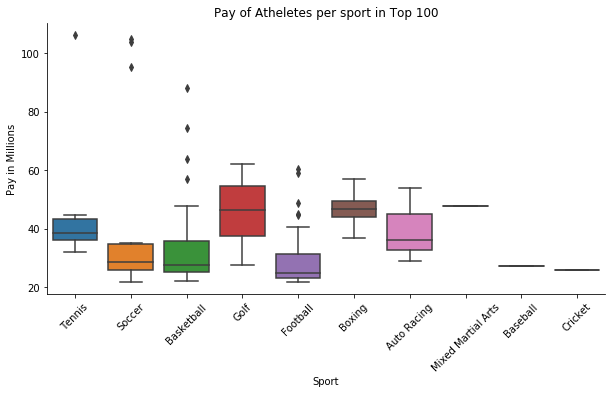

In [7]:
#Pay versus the sport 

plt.figure(figsize=(10,5))
sns.boxplot(x="Sport", y="Pay", data=data_df).set_title("Pay of Atheletes per sport in Top 100")
plt.xticks(rotation=45)
plt.ylabel("Pay in Millions")
sns.despine()

#here we see that the median of boxing is the highest

In [8]:
data_df.Sport.value_counts()

Basketball            35
Football              31
Soccer                14
Tennis                 6
Boxing                 4
Golf                   4
Auto Racing            3
Mixed Martial Arts     1
Cricket                1
Baseball               1
Name: Sport, dtype: int64

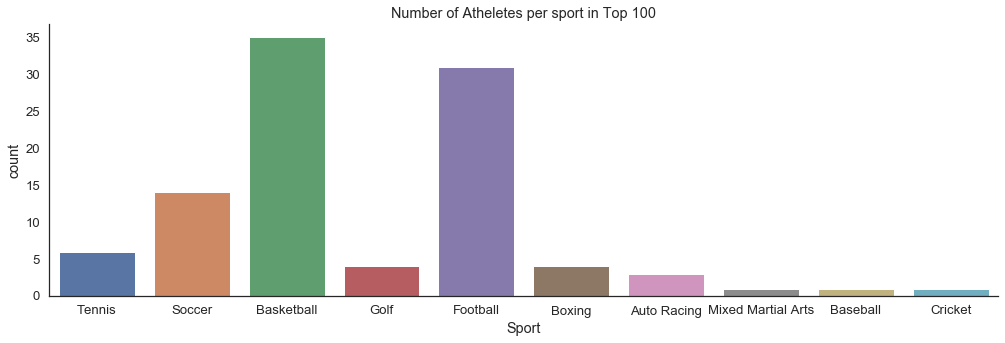

In [9]:
plt.figure(figsize=(17,5))
sns.set(style="white", font_scale=1.2)
sns.countplot(x="Sport", data=data_df).set_title("Number of Atheletes per sport in Top 100")
sns.despine()


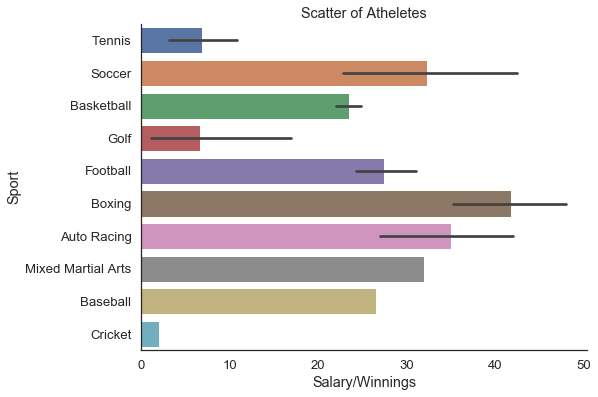

In [10]:
#boxing has higher salaries 

plt.figure(figsize=(8,6))
sns.barplot(y="Sport",x="Salary/Winnings" ,data=data_df).set_title("Scatter of Atheletes")
sns.despine()

In [19]:
#enhance the data further with more scraping 
#get age data from wikipedia 

import re

def _get_data(player, parameter):
    wiki_url = 'https://en.wikipedia.org/wiki/'
    url = wiki_url + player

    uClient = uReq(url)
    page_html = uClient.read()
    uClient.close()
    page_soup = soup(page_html, "html.parser")
    table = page_soup.find('table', { 'class' : 'infobox vcard' })
    
    try:
        table_rows = table.find_all('tr')
    except:
        try:
            table = page_soup.find('table', { 'class' : 'infobox biography vcard' })
            table_rows = table.find_all('tr')
        except:
            try:
                table = page_soup.find('table', { 'class' : 'infobox bordered vcard' })
                table_rows = table.find_all('tr')
            except:
                _get_data_when_error(player, parameter)
            
    birth_year = 0
    age = ''
    for row in table_rows:
        td = row.find_all('td')
        for i in td:
            if (i.text.find(parameter) >0):
                string = i.text                
                #print(string)
                birth_year = re.findall('\(.*?\)',string)[0]
                age = re.findall('\(.*?\)',string)[1]  
                return [int(age[5:7]), int(birth_year[1:5])]

#_get_data('Lewis_Hamilton','age')

In [12]:
import datetime

def _get_data_when_error(name, parameter):
    forbes_url = 'https://www.forbes.com/profile/'
    name = name.split('_')
    name = '-'.join(name)
    url = forbes_url + name
    
    current_year = datetime.datetime.now().year
    age = 0
    birth_year = 0    
     
    uClient = uReq(url)
    page_html = uClient.read()
    uClient.close()
    page_soup = soup(page_html, "html.parser")
    table = page_soup.find('div', { 'class' : 'profile-stats' })
    for row in table:
        #print(type(row), row.text)
        if parameter in row.text:
            age = int(row.text[3:]) 
            birth_year = current_year - age 
            return [int(age), int(birth_year)]
    
#_get_data_when_error('andre_drummond', 'Age')

In [21]:
import timeit
import unidecode

start = timeit.default_timer()

player_names = data_df.Name.values
Age = []
Birth_Year = []
for player in player_names:    
    player = unidecode.unidecode(player)
    player1 = player.split(" ")
    player1 = "_".join(player1)  
    
    player2 = player.lower()
    player2_formatted = []
    
    for name in player2.split(' '):
        temp = ''.join( e for e in name if e.isalnum())
        player2_formatted.append(temp)
    player2_formatted = '-'.join(player2_formatted)
        
    #we need the names in lower case and then need to remove any special characters in it 
    
    try:
        temp = _get_data(player1, 'age')
    except:
        temp = _get_data_when_error( player2_formatted , 'Age')
        
    Age.append(temp[0])
    Birth_Year.append(temp[1])    
     
        
end = timeit.default_timer() - start
print(f"Total time taken to scrape Age and Birth year of {len(player_names)} is : ", end)

Total time taken to scrape Age and Birth year of 100 is :  80.19157940000002


In [26]:
data_df['Age'] = Age
data_df['Birth_Year'] = Birth_Year


In [27]:
data_df.head()

,Name,Pay,Salary/Winnings,Endorsements,Sport,Age,Birth_Year
0,Roger Federer,106.3,6.3,100.0,Tennis,38,1981
1,Cristiano Ronaldo,105.0,60.0,45.0,Soccer,35,1985
2,Lionel Messi,104.0,72.0,32.0,Soccer,32,1987
3,Neymar,95.5,70.5,25.0,Soccer,28,1992
4,LeBron James,88.2,28.2,60.0,Basketball,35,1984


In [32]:
output_notebook()

Loading BokehJS ...

In [38]:
p = figure(title='Age vs Pay')
p.xaxis.axis_label = 'Pay'
p.yaxis.axis_label = 'Age'
p.scatter(data_df.Pay, data_df.Age, color="red")
show(p)

**Resources used**

https://stackoverflow.com/questions/60255593/bokeh-gives-me-an-empty-plot-with-columndatasource

https://programminghistorian.org/en/lessons/visualizing-with-bokeh

https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

https://docs.bokeh.org/en/latest/docs/user_guide/quickstart.html